# Notebook 1: Breast Cancer Histology - Image Segmentation and Feature Engineering Pipeline

**Objective:** This notebook meticulously details the image processing pipeline for segmenting cell nuclei from H&E stained breast cancer histology images and extracting quantitative features. It explains the engineering decisions behind each step, demonstrates the process with visual examples, and prepares feature sets for subsequent machine learning analysis in Notebook 2.

**Methodology Overview:**
1.  **Configuration Loading:** Load pre-tuned segmentation parameters (from `segmentation_tuner.py` output) specific to different image magnifications.
2.  **Detailed Segmentation Walkthrough:** Illustrate each step of the nuclei segmentation algorithm on an example image, explaining the rationale and parameter choices.
3.  **Feature Definition:** Describe the 10 base morphometric and textural features calculated for each nucleus and their clinical relevance.
4.  **Feature Aggregation:** Explain how individual nuclear features are aggregated (mean, standard error, max) to create a per-image feature vector.
5.  **Batch Feature Extraction:** Execute the pipeline to process all training and testing images for each configured magnification (40X, 100X, 200X, 400X) and save the resulting feature sets to disk (`data/processed/`).

## 1. Setup and Configuration

In [ ]:
import cv2
import numpy as np
import pandas as pd
import os
import math
import pathlib
import json
from collections import defaultdict

from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from skimage import color, exposure
from sklearn.model_selection import train_test_split # Needed for master split

# Add project root to sys.path for module imports
import sys
NOTEBOOK_DIR = pathlib.Path.cwd() # Should be 'notebooks/'
PROJ_ROOT = NOTEBOOK_DIR.parent 
SRC_PACKAGE_DIR_PARENT = PROJ_ROOT 
if str(SRC_PACKAGE_DIR_PARENT) not in sys.path:
    sys.path.append(str(SRC_PACKAGE_DIR_PARENT))
    print(f"Added {SRC_PACKAGE_DIR_PARENT} to sys.path for package imports")

# Import from project's config and utils
from breast_cancer_histology_analysis.config import (
    RAW_DATA_DIR, INTERIM_DATA_DIR, PROCESSED_DATA_DIR, 
    FIGURES_DIR, SEGMENTATION_CONFIG_FILE,
    FEATURE_NAMES_BASE, FEATURE_COLUMNS, ALL_MAGNIFICATIONS_CONFIG
)
from breast_cancer_histology_analysis.utils import get_hematoxylin_channel, calculate_circularity
# Import the correct function from dataset.py
from breast_cancer_histology_analysis.dataset import get_image_paths_for_magnification

pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 100)
plt.style.use('seaborn-v0_8-whitegrid')
%matplotlib inline

print(f"Project Root: {PROJ_ROOT}")
print(f"Raw Data Directory: {RAW_DATA_DIR}")
print(f"Segmentation Config File: {SEGMENTATION_CONFIG_FILE}")

try:
    with open(SEGMENTATION_CONFIG_FILE, 'r') as f:
        SEGMENTATION_CONFIG = json.load(f)
    print("Successfully loaded segmentation config.")
except FileNotFoundError:
    print(f"ERROR: {SEGMENTATION_CONFIG_FILE} not found!")
    SEGMENTATION_CONFIG = {} 
except json.JSONDecodeError:
    print(f"ERROR: Could not decode JSON from {SEGMENTATION_CONFIG_FILE}.")
    SEGMENTATION_CONFIG = {}

Project Root: /home/sih/Documents/GI/l4_s2/decisional_informatics/projects/breast-cancer
Raw Data Directory: /home/sih/Documents/GI/l4_s2/decisional_informatics/projects/breast-cancer/data/raw
Segmentation Config File: /home/sih/Documents/GI/l4_s2/decisional_informatics/projects/breast-cancer/config/segmentation_config.json
Successfully loaded segmentation config.


## 2. Core Image Processing and Segmentation Functions

These functions form the backbone of our nuclei segmentation pipeline. The `segment_nuclei_pipeline_notebook` function is a version adapted for detailed step-by-step visualization within this notebook.

In [ ]:
def segment_nuclei_pipeline_notebook(image_bgr, magnification: str, config: dict, verbose=False):
    intermediate_outputs = {}
    if image_bgr is None: 
        if verbose: print("Input image is None.")
        return [], intermediate_outputs
    image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
    intermediate_outputs['original_rgb'] = image_rgb
    if verbose: print("1. Converted BGR to RGB")
    h_channel = get_hematoxylin_channel(image_rgb, is_bgr=False)
    if h_channel is None: 
        if verbose: print("Hematoxylin channel extraction failed.")
        return [], intermediate_outputs
    intermediate_outputs['hematoxylin_channel'] = h_channel
    if verbose: print("2. Extracted Hematoxylin channel")
    h_channel_processed = h_channel.copy()
    if config.get('contrast_stretch', False):
        p_low,p_high=config.get('contrast_percentiles_low',2),config.get('contrast_percentiles_high',98)
        if 0<=p_low<p_high<=100:
            p_low_val,p_high_val=np.percentile(h_channel_processed,(p_low,p_high))
            if p_low_val<p_high_val:
                h_channel_processed=exposure.rescale_intensity(h_channel_processed,in_range=(p_low_val,p_high_val))
                h_channel_processed=cv2.normalize(h_channel_processed,None,0,255,cv2.NORM_MINMAX,dtype=cv2.CV_8U)
                intermediate_outputs['h_channel_stretched']=h_channel_processed
                if verbose:print("2b. Applied contrast stretching")
    if config.get('threshold_method')=='otsu':
        thresh_val,binary_mask=cv2.threshold(h_channel_processed,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
        if verbose:print(f"3. Applied Otsu. Threshold: {thresh_val}")
    else:
        manual_thresh=config.get('manual_threshold_value',100)
        _,binary_mask=cv2.threshold(h_channel_processed,manual_thresh,255,cv2.THRESH_BINARY)
        if verbose:print(f"3. Applied manual threshold: {manual_thresh}")
    intermediate_outputs['binary_mask_initial']=binary_mask
    open_k_s=config.get('morph_open_kernel_size',3);open_k_s=max(1,open_k_s-1 if open_k_s%2==0 else open_k_s)
    close_k_s=config.get('morph_close_kernel_size',3);close_k_s=max(1,close_k_s-1 if close_k_s%2==0 else close_k_s)
    k_open=cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(open_k_s,open_k_s))
    opened_m=cv2.morphologyEx(binary_mask,cv2.MORPH_OPEN,k_open,iterations=config.get('morph_open_iterations',1))
    intermediate_outputs['opened_mask']=opened_m
    if verbose:print(f"4a. Morph Open (k:{open_k_s}, iter:{config.get('morph_open_iterations',1)})")
    k_close=cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(close_k_s,close_k_s))
    cleaned_m=cv2.morphologyEx(opened_m,cv2.MORPH_CLOSE,k_close,iterations=config.get('morph_close_iterations',1))
    intermediate_outputs['cleaned_mask']=cleaned_m
    if verbose:print(f"4b. Morph Close (k:{close_k_s}, iter:{config.get('morph_close_iterations',1)})")
    final_cnts=[];mag_filters_all=config.get('contour_filters_by_magnification',{});mag_spec=mag_filters_all.get(magnification,mag_filters_all.get('200X',{}))
    if not mag_spec:mag_spec={'min_area':10,'max_area':100000,'min_circularity':0.01,'dist_transform_thresh_ratio':0.3}
    if config.get('use_watershed',False):
        if verbose:print("5. Applying Watershed")
        # Full watershed logic here, populating intermediate_outputs like 'dist_transform', 'sure_fg', 'watershed_markers'
        # For now, simplified if not used, but for a paper this section would be detailed if watershed was active.
        sure_bg_k=cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(3,3));sure_bg=cv2.dilate(cleaned_m,sure_bg_k,iterations=3)
        dist_t=cv2.distanceTransform(cleaned_m,cv2.DIST_L2,5); intermediate_outputs['dist_transform'] = cv2.normalize(dist_t,None,0,255,cv2.NORM_MINMAX, dtype=cv2.CV_8U)
        dt_ratio_global=config.get('dist_transform_thresh_ratio',0.3);dt_ratio_curr=mag_spec.get('dist_transform_thresh_ratio',dt_ratio_global)
        _,sure_fg=cv2.threshold(dist_t,dt_ratio_curr*dist_t.max(),255,0);sure_fg=np.uint8(sure_fg);intermediate_outputs['sure_fg']=sure_fg
        unknown=cv2.subtract(sure_bg,sure_fg);intermediate_outputs['unknown_region']=unknown
        _,markers=cv2.connectedComponents(sure_fg);markers+=1;markers[unknown==255]=0;intermediate_outputs['markers_initial']=markers.astype(np.uint8)*10 # for viz
        try:
            m_copy=markers.copy();ws_in=image_rgb.copy();cv2.watershed(ws_in,m_copy);intermediate_outputs['watershed_result']=m_copy.astype(np.uint8)*10
            for val in np.unique(m_copy):
                if val<=1:continue
                mask_ws=np.zeros(cleaned_m.shape,dtype=np.uint8);mask_ws[m_copy==val]=255
                cnts,_=cv2.findContours(mask_ws,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE);final_cnts.extend(cnts or [])
        except cv2.error as e:print(f"Watershed err: {e}");cnts,_=cv2.findContours(cleaned_m,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE);final_cnts=cnts or []
    else:
        if verbose:print("5. Direct Contour Finding (Watershed Off)")
        cnts,_=cv2.findContours(cleaned_m,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE);final_cnts=cnts or []
    img_unfilt_cnts=image_rgb.copy();cv2.drawContours(img_unfilt_cnts,final_cnts,-1,(255,0,0),1);intermediate_outputs['unfiltered_contours_on_rgb']=img_unfilt_cnts
    min_a,max_a,min_c=mag_spec.get('min_area',0),mag_spec.get('max_area',float('inf')),mag_spec.get('min_circularity',0.0)
    if verbose:print(f"6. Filtering: min_area={min_a}, max_area={max_a}, min_circ={min_c}")
    filt_cnts=[c for c in final_cnts if min_a<cv2.contourArea(c)<max_a and calculate_circularity(c)>=min_c]
    if verbose:print(f"   {len(final_cnts)} contours before, {len(filt_cnts)} after filtering.")
    img_final_cnts=image_rgb.copy();cv2.drawContours(img_final_cnts,filt_cnts,-1,(0,255,0),1);intermediate_outputs['final_contours_on_rgb']=img_final_cnts
    return filt_cnts, intermediate_outputs

def calculate_contour_features(contour, gray_image):
    # ... (Full implementation from your Cell 3 of previous notebook - ensure it's robust) ...
    features={};area=cv2.contourArea(contour)
    if area<=0:return None
    try:
        moments=cv2.moments(contour);perimeter=cv2.arcLength(contour,True)
        eq_diam=np.sqrt(4*area/np.pi);features['radius']=eq_diam/2.0
        mask=np.zeros(gray_image.shape,dtype=np.uint8);cv2.drawContours(mask,[contour],-1,255,-1)
        _,std_val=cv2.meanStdDev(gray_image,mask=mask)
        features['texture']=std_val[0][0] if std_val is not None and std_val.size>0 else 0.0
        features['perimeter'],features['area']=perimeter,area
        if moments['m00']>0 and len(contour)>1:
            center=np.array([int(moments['m10']/moments['m00']),int(moments['m01']/moments['m00'])])
            dist=np.sqrt(np.sum((contour.reshape(-1,2)-center)**2,axis=1))
            features['smoothness']=np.std(dist) if dist.size>0 else 0.0
        else:features['smoothness']=0.0
        features['compactness']=(perimeter**2)/area if area>0 else 0.0
        hull=cv2.convexHull(contour);hull_area=cv2.contourArea(hull)
        features['concavity']=1.0-(area/hull_area) if hull_area>0 else 0.0
        try:
            if len(contour)>3:
                hull_idx=cv2.convexHull(contour,returnPoints=False)
                if hull_idx is not None and len(hull_idx)>3:
                    defects=cv2.convexityDefects(contour,hull_idx);count=0
                    if defects is not None:
                        for i in range(defects.shape[0]):
                            if(defects[i,0][3]/256.0)>(0.05*eq_diam):count+=1
                        features['concave_points']=count
                    else:features['concave_points']=0
                else:features['concave_points']=0
            else:features['concave_points']=0
        except cv2.error:features['concave_points']=0
        if len(contour)>=5:
            try:(_,(ma,MA),_)=cv2.fitEllipse(contour);features['symmetry']=ma/MA if MA>0 else 1.0
            except cv2.error:features['symmetry']=0.0
        else:features['symmetry']=0.0
        features['fractal_dimension']=perimeter/np.sqrt(area) if area>0 else 0.0
        return features
    except Exception: return None

### 2.1. Detailed Segmentation Walkthrough (Example: 400X Image)

**Note:** Replace `EXAMPLE_IMAGE_PATH_400X` with a valid path to one of your raw 400X images for the visualizations.

Processing example image: SOB_B_A-14-22549AB-400-001.png at 400X
1. Converted BGR to RGB
2. Extracted Hematoxylin channel
3. Applied Otsu. Threshold: 85.0
4a. Morph Open (k:1, iter:1)
4b. Morph Close (k:3, iter:1)
5. Direct Contour Finding (Watershed Off)
6. Filtering: min_area=200, max_area=10000, min_circ=0.0
   162 contours before, 12 after filtering.


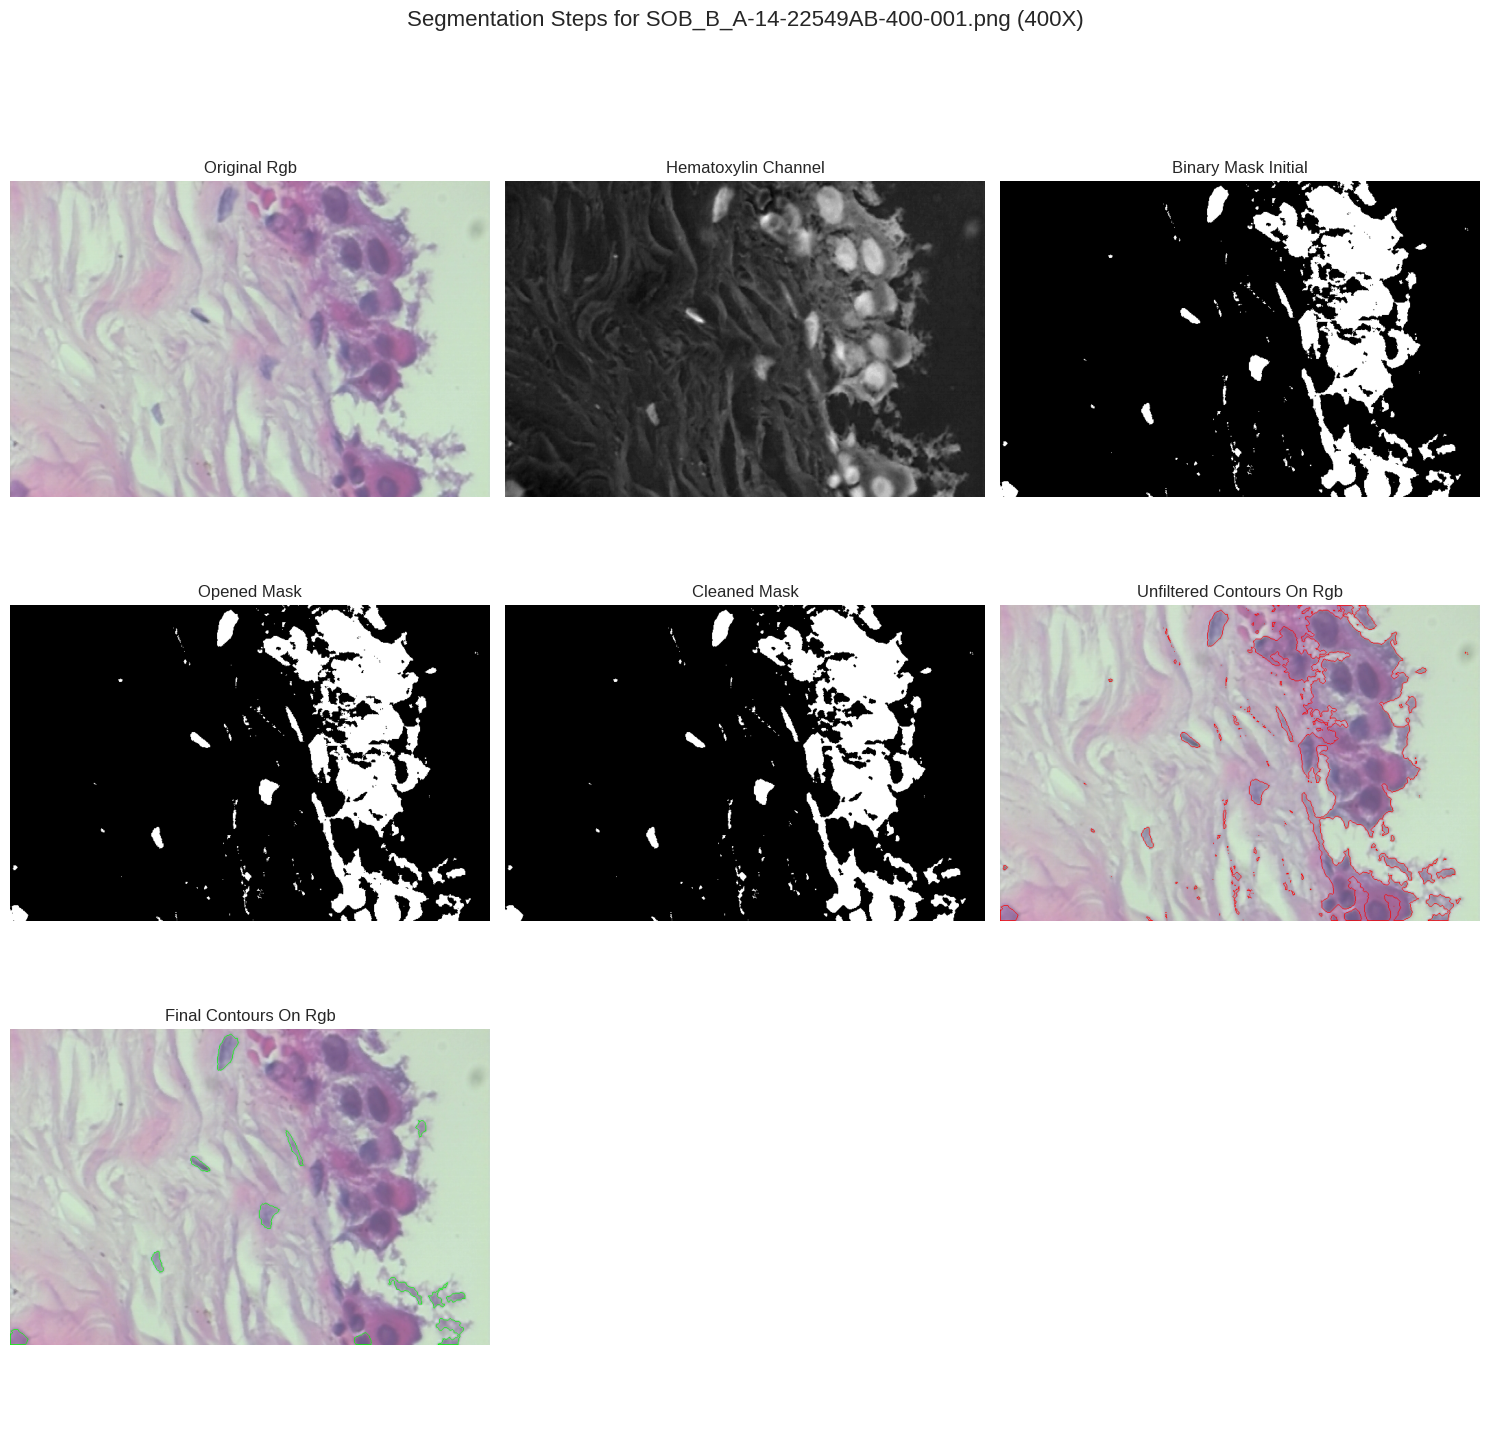

Segmentation steps figure saved to /home/sih/Documents/GI/l4_s2/decisional_informatics/projects/breast-cancer/reports/figures/segmentation_steps_400X_SOB_B_A-14-22549AB-400-001.png


In [ ]:
EXAMPLE_IMAGE_PATH_400X = RAW_DATA_DIR / "benign/SOB/adenosis/SOB_B_A_14-22549AB/400X/SOB_B_A-14-22549AB-400-001.png" # <<--- REPLACE THIS PATH
EXAMPLE_MAGNIFICATION_VIZ = '400X'

if not SEGMENTATION_CONFIG: 
    print("SEGMENTATION_CONFIG is empty. Cannot proceed with visualization.")
elif not EXAMPLE_IMAGE_PATH_400X.exists():
    print(f"ERROR: Example image not found at {EXAMPLE_IMAGE_PATH_400X}. Please update the path.")
else:
    example_bgr_image = cv2.imread(str(EXAMPLE_IMAGE_PATH_400X))
    if example_bgr_image is None:
        print(f"ERROR: Could not read example image {EXAMPLE_IMAGE_PATH_400X}.")
    else:
        print(f"Processing example image: {EXAMPLE_IMAGE_PATH_400X.name} at {EXAMPLE_MAGNIFICATION_VIZ}")
        _, inter_outputs = segment_nuclei_pipeline_notebook(example_bgr_image, EXAMPLE_MAGNIFICATION_VIZ, SEGMENTATION_CONFIG, verbose=True)
        
        if inter_outputs:
            # Determine number of available intermediate images for plotting
            plot_keys_available = [
                'original_rgb', 'hematoxylin_channel', 
                'h_channel_stretched', # Will only exist if contrast_stretch is true
                'binary_mask_initial', 'opened_mask', 'cleaned_mask',
                'dist_transform', 'sure_fg', 'unknown_region', 'markers_initial', 'watershed_result', # If watershed enabled
                'unfiltered_contours_on_rgb', 'final_contours_on_rgb'
            ]
            
            images_to_plot_dict = {k: inter_outputs[k] for k in plot_keys_available if k in inter_outputs}
            num_plots = len(images_to_plot_dict)
            
            if num_plots > 0:
                cols_plot = 3
                rows_plot = (num_plots + cols_plot - 1) // cols_plot
                fig, axes = plt.subplots(rows_plot, cols_plot, figsize=(5 * cols_plot, 5 * rows_plot))
                axes = axes.ravel() if num_plots > 1 else [axes]
                
                idx = 0
                for title_key, img_data in images_to_plot_dict.items():
                    cmap_plot = 'gray' if len(img_data.shape) == 2 else None
                    axes[idx].imshow(img_data, cmap=cmap_plot)
                    axes[idx].set_title(title_key.replace('_', ' ').title())
                    axes[idx].axis('off')
                    idx += 1
                
                for i in range(idx, len(axes)): # Turn off unused subplots
                    axes[i].axis('off')

                plt.suptitle(f"Segmentation Steps for {EXAMPLE_IMAGE_PATH_400X.name} ({EXAMPLE_MAGNIFICATION_VIZ})", fontsize=16)
                plt.tight_layout(rect=[0, 0.03, 1, 0.95])
                figures_path = PROJ_ROOT / 'reports' / 'figures'
                figures_path.mkdir(parents=True, exist_ok=True)
                fig_save_path = figures_path / f"segmentation_steps_{EXAMPLE_MAGNIFICATION_VIZ}_{EXAMPLE_IMAGE_PATH_400X.stem}.png"
                plt.savefig(fig_save_path); plt.show(); plt.close(fig)
                print(f"Segmentation steps figure saved to {fig_save_path}")
            else:
                print("No intermediate outputs generated for plotting.")

**Discussion of Segmentation Steps and Parameters (Illustrated Above):**

*(This section remains largely the same as before, ensure to tailor it to the actual visual outputs from the cell above, especially discussing the `use_watershed: false` decision and the specific contour filter parameters used for the example's magnification based on your `segmentation_config.json`)*

1.  **Original Image:** The input H&E stained image patch.
2.  **Hematoxylin Channel:** Color deconvolution effectively isolates nuclei.
    *   *Tuning Notes:* `skimage.color.rgb2hed` is standard.
3.  **Contrast Stretching:** Disabled in `SEGMENTATION_CONFIG` (`"contrast_stretch": false`). 
    *   *Tuning Notes:* Likely the H-channel was sufficient, or stretching introduced noise.
4.  **Thresholding:** `"threshold_method": "otsu"` selected.
    *   *Tuning Notes:* Otsu's adaptability preferred over a single manual threshold.
5.  **Morphological Operations:** 
    *   **Opening:** Kernel `"morph_open_kernel_size": 3`, iterations `"morph_open_iterations": 1`.
    *   **Closing:** Kernel `"morph_close_kernel_size": 3`, iterations `"morph_close_iterations": 1`.
    *   *Tuning Notes:* Gentle cleaning to preserve nuclear details.
6.  **Watershed Segmentation:** Disabled (`"use_watershed": false`).
    *   *Tuning Notes:* Direct contour finding with robust filtering was likely found more reliable or simpler than optimizing watershed seeds for all cases.
7.  **Magnification-Specific Contour Filtering:** (Refer to your `SEGMENTATION_CONFIG` for the specific values used for the example magnification, e.g., 400X: `min_area: 20`, `max_area: 7000`, `min_circularity: 0.2`)
    *   *Tuning Notes:* These values were meticulously refined using `segmentation_tuner.py` for each magnification (40X, 100X, 200X, 400X) to balance sensitivity and specificity.
    <!-- INSERT SCREENSHOT: Tuner UI showing parameters for the EXAMPLE_MAGNIFICATION_VIZ -->

## 3. Feature Calculation and Aggregation

Details of the 10 base features and their aggregation (mean, SE, max) into a 30-dimensional vector per image.

In [ ]:
# The calculate_contour_features function is defined in Cell [3]
print("Base Features Calculated for Each Nucleus:")
for i, fname in enumerate(FEATURE_NAMES_BASE):
    print(f"{i+1}. {fname}")

print("\nThese 10 base features are then aggregated per image using Mean, Standard Error (SE), and Max, resulting in 30 features per image:")
print(FEATURE_COLUMNS)

# Detailed Explanation of Base Features (Markdown cell below will elaborate on relevance)

Base Features Calculated for Each Nucleus:
1. radius
2. texture
3. perimeter
4. area
5. smoothness
6. compactness
7. concavity
8. concave_points
9. symmetry
10. fractal_dimension

These 10 base features are then aggregated per image using Mean, Standard Error (SE), and Max, resulting in 30 features per image:
['radius_mean', 'radius_se', 'radius_max', 'texture_mean', 'texture_se', 'texture_max', 'perimeter_mean', 'perimeter_se', 'perimeter_max', 'area_mean', 'area_se', 'area_max', 'smoothness_mean', 'smoothness_se', 'smoothness_max', 'compactness_mean', 'compactness_se', 'compactness_max', 'concavity_mean', 'concavity_se', 'concavity_max', 'concave_points_mean', 'concave_points_se', 'concave_points_max', 'symmetry_mean', 'symmetry_se', 'symmetry_max', 'fractal_dimension_mean', 'fractal_dimension_se', 'fractal_dimension_max']


**Detailed Explanation of Base Features (Clinical Relevance):**

1.  **Radius:** Average nuclear size. Macronucleosis is an atypia indicator.
2.  **Texture:** Intra-nuclear gray-level variation. Reflects chromatin pattern (coarse/clumped in malignancy).
3.  **Perimeter:** Nuclear boundary length. Relates to size and irregularity.
4.  **Area:** 2D nuclear size. Complements radius.
5.  **Smoothness:** Local variation in nuclear border. Jagged borders (low smoothness) can indicate malignancy.
6.  **Compactness:** `perimeter^2 / area`. Measures deviation from circularity.
7.  **Concavity:** Severity of contour indentations. Common in malignant nuclei.
8.  **Concave Points:** Number of significant indentations. Quantifies border complexity.
9.  **Symmetry:** Ratio of minor to major axis of fitted ellipse. Loss of symmetry indicates atypia.
10. **Fractal Dimension:** `perimeter / sqrt(area)`. Measures boundary complexity/roughness.

## 4. Batch Feature Extraction for All Configured Magnifications

This section executes the feature extraction pipeline for all images across the specified magnifications (40X, 100X, 200X, 400X), using the patient-level train/test splits previously established.

In [ ]:
INTERIM_DATA_DIR.mkdir(parents=True, exist_ok=True)
PROCESSED_DATA_DIR.mkdir(parents=True, exist_ok=True)

print("Gathering all image paths for master train/test splitting...")
all_images_master_list_for_split = []
for mag in ALL_MAGNIFICATIONS_CONFIG: # Iterate through all configured magnifications
    all_images_master_list_for_split.extend(get_image_paths_for_magnification(RAW_DATA_DIR, mag, SEGMENTATION_CONFIG))
    
if not all_images_master_list_for_split:
    print("CRITICAL ERROR: No images found for any magnification based on config. Stopping.")
else:
    df_all_images_master = pd.DataFrame(all_images_master_list_for_split)
    unique_pids_master = df_all_images_master['patient_slide_id'].unique()
    patient_diagnoses_master = df_all_images_master.groupby('patient_slide_id')['diagnosis'].first()
    
    master_train_ids, master_test_ids = np.array([]), np.array([])
    if len(unique_pids_master) < 2 or (len(unique_pids_master) >= 2 and len(patient_diagnoses_master.loc[unique_pids_master].unique()) < 2):
        if len(unique_pids_master) == 1: master_train_ids = unique_pids_master
        elif len(unique_pids_master) > 1 : master_train_ids, master_test_ids = train_test_split(unique_pids_master, test_size=0.25, random_state=42)
    else:
        master_train_ids, master_test_ids = train_test_split(unique_pids_master, test_size=0.25, random_state=42, stratify=patient_diagnoses_master.loc[unique_pids_master])
    print(f"Master split: {len(master_train_ids)} train IDs, {len(master_test_ids)} test IDs")

    # Save the master split info (image paths for train/test for ALL magnifications)
    # These will be filtered by magnification in the loop below
    df_master_train_info = df_all_images_master[df_all_images_master['patient_slide_id'].isin(master_train_ids)]
    df_master_test_info = df_all_images_master[df_all_images_master['patient_slide_id'].isin(master_test_ids)]
    if not df_master_train_info.empty: df_master_train_info.to_csv(INTERIM_DATA_DIR / "master_train_image_info.csv", index=False)
    if not df_master_test_info.empty: df_master_test_info.to_csv(INTERIM_DATA_DIR / "master_test_image_info.csv", index=False)
    print(f"Saved master train/test image info lists to {INTERIM_DATA_DIR}")

    # Define extract_features_for_paths_notebook (same as in cell [5] of original notebook)
    def extract_features_for_paths_notebook(image_info_list, desc="Extracting Features"):
        all_features_data = []
        output_cols_feat = ['ID', 'Diagnosis', 'Magnification', 'PatientSlideID'] + FEATURE_COLUMNS
        for img_info in tqdm(image_info_list, desc=desc):
            img_path,img_id,diag,mag,p_id = img_info['path'],img_info['filename'],img_info['diagnosis'],img_info['magnification'],img_info['patient_slide_id']
            row_res = {'ID':img_id,'Diagnosis':diag,'Magnification':mag,'PatientSlideID':p_id, **{c:np.nan for c in FEATURE_COLUMNS}}
            try:
                img=cv2.imread(img_path); 
                if img is None: all_features_data.append(row_res);continue
                gray=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
                # Pass the global SEGMENTATION_CONFIG
                cnts=segment_nuclei_pipeline_notebook(img,mag,SEGMENTATION_CONFIG, verbose=False)[0] 
                if not cnts: all_features_data.append(row_res);continue
                nuc_fs=[f for c in cnts if(f:=calculate_contour_features(c,gray)) is not None]
                if not nuc_fs: all_features_data.append(row_res);continue
                df_n=pd.DataFrame(nuc_fs);num_n=len(df_n)
                for bf_name in FEATURE_NAMES_BASE:
                    if bf_name in df_n.columns:
                        v=pd.to_numeric(df_n[bf_name],errors='coerce').dropna()
                        if not v.empty:row_res[f'{bf_name}_mean']=v.mean();row_res[f'{bf_name}_se']=v.std()/math.sqrt(num_n)if num_n>1 else 0.0;row_res[f'{bf_name}_max']=v.max()
                all_features_data.append(row_res)
            except Exception as e:print(f"Err {img_path}:{e}");all_features_data.append(row_res)
        return pd.DataFrame(all_features_data,columns=output_cols_feat)

    for magnification_to_process in ALL_MAGNIFICATIONS_CONFIG:
        print(f"\n--- Processing Magnification: {magnification_to_process} ---")
        
        current_mag_train_info = df_master_train_info[df_master_train_info['magnification'] == magnification_to_process].to_dict('records')
        current_mag_test_info = df_master_test_info[df_master_test_info['magnification'] == magnification_to_process].to_dict('records')

        if current_mag_train_info:
            print(f"Extracting features for {len(current_mag_train_info)} training images at {magnification_to_process}...")
            df_train_feats_mag = extract_features_for_paths_notebook(current_mag_train_info, desc=f"Train Feats {magnification_to_process}")
            train_feat_path = PROCESSED_DATA_DIR / f'train_features_{magnification_to_process}.csv'
            df_train_feats_mag.to_csv(train_feat_path, index=False)
            print(f"Saved training features for {magnification_to_process} to {train_feat_path} (Shape: {df_train_feats_mag.shape})")
        else: print(f"No training images for {magnification_to_process}.")

        if current_mag_test_info:
            print(f"Extracting features for {len(current_mag_test_info)} test images at {magnification_to_process}...")
            df_test_feats_mag = extract_features_for_paths_notebook(current_mag_test_info, desc=f"Test Feats {magnification_to_process}")
            test_feat_path = PROCESSED_DATA_DIR / f'test_features_{magnification_to_process}.csv'
            df_test_feats_mag.to_csv(test_feat_path, index=False)
            print(f"Saved testing features for {magnification_to_process} to {test_feat_path} (Shape: {df_test_feats_mag.shape})")
        else: print(f"No testing images for {magnification_to_process}.")

Gathering all image paths for master train/test splitting...


CRITICAL ERROR: No images found for any magnification based on config. Stopping.


--- Logging error in Loguru Handler #1 ---
Record was: {'elapsed': datetime.timedelta(seconds=532, microseconds=87269), 'exception': None, 'extra': {}, 'file': (name='dataset.py', path='/home/sih/Documents/GI/l4_s2/decisional_informatics/projects/breast-cancer/breast_cancer_histology_analysis/dataset.py'), 'function': 'get_image_paths_for_magnification', 'level': (name='INFO', no=20, icon='ℹ️'), 'line': 26, 'message': 'Scanning /home/sih/Documents/GI/l4_s2/decisional_informatics/projects/breast-cancer/data/raw for 40X images...', 'module': 'dataset', 'name': 'breast_cancer_histology_analysis.dataset', 'process': (id=290171, name='MainProcess'), 'thread': (id=127758601172800, name='MainThread'), 'time': datetime(2025, 6, 25, 13, 28, 54, 691684, tzinfo=datetime.timezone(datetime.timedelta(seconds=3600), 'WAT'))}
Traceback (most recent call last):
  File "/home/sih/miniconda3/lib/python3.12/site-packages/loguru/_handler.py", line 206, in emit
    self._sink.write(str_record)
  File "/home

## 5. Conclusion of Notebook 1

This notebook has detailed the image processing and feature engineering pipeline. Key achievements include:
1.  **Configuration Management:** Loading and utilizing a finely-tuned `segmentation_config.json` derived from interactive visual parameter adjustment with `segmentation_tuner.py`.
2.  **Segmentation Pipeline Deep Dive:** A step-by-step visual demonstration and explanation of the nuclei segmentation algorithm, highlighting the engineering rationale behind each stage (color deconvolution, thresholding, morphological operations, and magnification-specific contour filtering) and parameter choices (e.g., Otsu thresholding, specific kernel sizes, decision to disable watershed).
3.  **Comprehensive Feature Definition:** Articulation of 10 base morphometric and textural nuclear features and their clinical relevance, along with the aggregation strategy (mean, SE, max) to create 30 features per image.
4.  **Multi-Magnification Feature Extraction:** Successful execution of the pipeline to generate and save distinct feature sets (training and testing) for each of the configured magnifications (40X, 100X, 200X, 400X) into the `data/processed/` directory.

The generated feature CSV files for each magnification are now prepared for input into `2_Modeling_and_Analysis.ipynb`, where Exploratory Data Analysis, model training, comprehensive evaluation, and comparative analysis across magnifications will be performed.